In [1]:
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib

Generate $D_\theta$ according to some prior distribution

In [2]:
d = 1
sigma_theta =torch.eye(d)
mu_theta =torch.zeros(d)
prior_distribution = torch.distributions.MultivariateNormal(mu_theta, sigma_theta) 

prior_log_prob = lambda samples: prior_distribution.log_prob(samples)

n_D = 100
D_theta =torch.linspace(-4,4, n_D).unsqueeze(-1)

Generate $D_x$ according to some unknown linear regression model $f(D_\theta)$

In [3]:
sigma_simulateur = .5
f = lambda y: 1*torch.ones(d)@y.T+1
simulateur= lambda theta: f(theta) + torch.randn(theta.shape[0])*sigma_simulateur

D_x = simulateur(D_theta)

Generate $x_0$ according to $f(\theta_0)$ for some unknown $\theta_0$

In [4]:
theta_0 = prior_distribution.sample()
print('theta_0 = ' + str(theta_0.item()))
n_x0= 1000
x0 = simulateur(theta_0.unsqueeze(0).repeat(n_x0, 1))

theta_0 = 0.51301509141922


Scatter plot of $D$, unknown linear model $f$, histogram of $x_0$

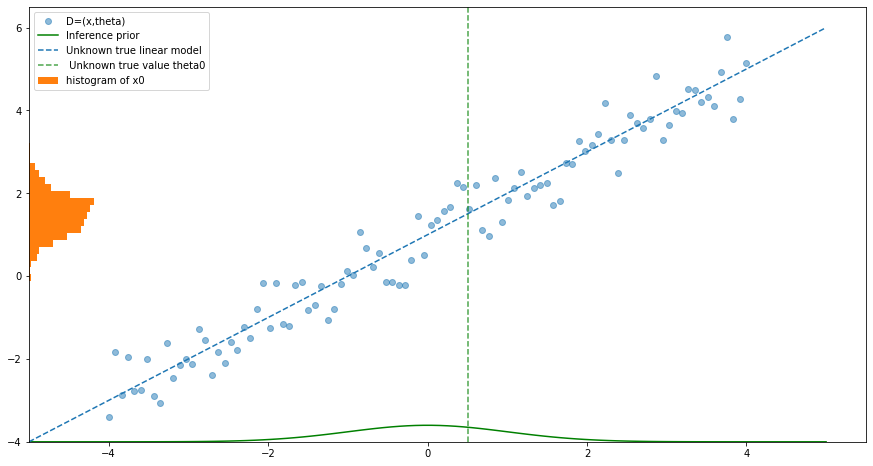

In [5]:
plt.figure(figsize = (15,8))
y_min = -4
plt.scatter(D_theta[:,0].numpy(), D_x.numpy(), alpha =.5, label = 'D=(x,theta)') 
tt = torch.linspace(-5,5,100)
plt.plot(tt, y_min + torch.exp(prior_distribution.log_prob(tt.unsqueeze(-1))), color = 'green', label='Inference prior')
plt.plot(tt.numpy(),f(tt.unsqueeze(-1)).numpy(), linestyle = '--', label = 'Unknown true linear model')
plt.axvline(theta_0.numpy(), color = 'green', alpha = .7, linestyle = '--', label=' Unknown true value theta0')
hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -5, label = 'histogram of x0')
plt.ylim(y_min,)
plt.legend()

In [6]:
class bayesian_linear_regression:
    def __init__(self, x_samples, theta_samples, x0, sigma_simulateur, mu_theta, sigma_theta): 
        self.x_samples = x_samples
        self.theta_samples = theta_samples
        self.num_samples = x_samples.shape[0]
        self.d = theta_samples.shape[-1]
        
        self.sigma_simulateur = sigma_simulateur
        self.mu_theta = mu_theta
        self.sigma_theta = sigma_theta 
        
        self.mu_phi = torch.zeros(self.d+1)
        self.sigma_phi = torch.eye(self.d+1)

        self.mu_phi_D, self.sigma_phi_D = self.compute_parameter_posterior_parameter()
        self.parameter_posterior_distribution = torch.distributions.MultivariateNormal(self.mu_phi_D, self.sigma_phi_D)
        self.x0=x0
    
    def compute_parameter_likelihood(self, D_theta, D_x):
        assert D_theta.shape[0]>=2,'Must have more than 1 dataset sample'
        assert D_theta.shape[0]==D_x.shape[0], 'Mismatch in number samples'
        temp = torch.cat([D_theta, torch.ones(D_theta.shape[0]).unsqueeze(-1)], dim = -1)
        sigma_d_phi = torch.inverse(temp.T@temp)*self.sigma_simulateur**2
        mu_d_phi = D_x@temp@torch.inverse(temp.T@temp)
        return mu_d_phi,sigma_d_phi 

    def dataset_likelihood(self, beta): 
        assert self.num_samples>=1,'No dataset'
        temp = torch.cat([self.theta_samples, torch.ones(self.theta_samples.shape[0]).unsqueeze(-1)], dim = -1)
        mean = beta@temp.T
        sigma = (self.sigma_simulateur**2)*torch.eye(self.d).unsqueeze(0).repeat(self.theta_samples.shape[0],1,1)
        return torch.distributions.MultivariateNormal(mean.unsqueeze(-1),sigma).log_prob(self.x_samples.unsqueeze(-1))
    
    def parameter_log_likelihood(self,theta, x0, beta):
        assert theta.shape[-1]==self.d, 'wrong theta dimension'
        assert x0.shape[-1] == 1, 'wrong x0 dimension'
        assert theta.shape[:-1] == x0.shape[:-1], 'mismatch in batch sizes'
        mean = torch.cat([theta, torch.ones(theta.shape)], dim = -1)@beta.unsqueeze(-1)
        var = self.sigma_simulateur*torch.eye(1).unsqueeze(0).unsqueeze(1).repeat(x0.shape[0], x0.shape[1],1,1)
        return torch.distributions.MultivariateNormal(mean,var).log_prob(x0)
        
    def compute_parameter_posterior_parameter(self, D_theta= None, D_x = None):
        if D_theta is None:
            D_theta = self.theta_samples
        if D_x == None: 
            D_x = self.x_samples
        assert D_theta.shape[0] == D_x.shape[0],'Mismatch in number samples'
        if D_theta.shape[0]>=1:
            temp = torch.cat([D_theta, torch.ones(D_theta.shape[0]).unsqueeze(-1)], dim = -1)
            sigma_phi_d = torch.inverse(temp.T@temp/self.sigma_simulateur**2 + torch.inverse(self.sigma_phi))
            mu_phi_d = sigma_phi_d@(D_x@temp/self.sigma_simulateur**2+ torch.inverse(self.sigma_phi)@self.mu_phi)
        else:
            mu_phi_d, sigma_phi_d = self.mu_phi, self.sigma_phi 
        return mu_phi_d,sigma_phi_d
        

    def log_joint_distribution(self, theta, phi):
        log_prior = torch.distributions.MultivariateNormal(self.mu_theta, self.sigma_theta).log_prob(theta)
        augmented_theta = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1)
        temp = torch.bmm(phi.unsqueeze(-2),augmented_theta.unsqueeze(-1)).squeeze(-1)
        temp = temp.repeat(1,self.x0.shape[0])
        cov_matrix = sigma_simulateur * torch.eye(self.x0.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        log_likelihood = torch.distributions.MultivariateNormal(temp, cov_matrix).log_prob(self.x0) if self.x0.shape[0]>=1 else torch.zeros(theta.shape[0])
        log_parameter_posterior = self.parameter_posterior_distribution.log_prob(phi)
        return log_parameter_posterior+log_prior+log_likelihood
    
    def marginal_log_likelihood_parameters(self, x, theta): 
        mu_phi_d, sigma_phi_d = self.compute_parameter_posterior_parameter()
        gamma = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1).unsqueeze(1).repeat(1,x.shape[0],1)
        mean = gamma@mu_phi_d
        cov = gamma@sigma_phi_d.unsqueeze(0).repeat(theta.shape[0],1,1)@torch.transpose(gamma, -2,-1) + self.sigma_simulateur*torch.eye(x.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        return mean, cov
    
    def marginal_log_likelihood(self, x, theta):
        mean, cov = self.marginal_log_likelihood_parameters(x, theta)
        return torch.distributions.MultivariateNormal(mean, cov).log_prob(x)
    
    def sample_marginal_likelihood(self, num_samples, theta):
        mean, cov = self.marginal_log_likelihood_parameters(torch.zeros(num_samples), theta)
        return torch.distributions.MultivariateNormal(mean, cov).sample()
    
    def compute_posterior_distribution_parameters(self,beta):
        sigma_theta_x0_phi = torch.inverse(torch.inverse(self.sigma_theta) + (self.x0.shape[0]*beta[0]**2)/self.sigma_simulateur**2)
        mu_theta_x0_phi = sigma_theta_x0_phi@(torch.inverse(self.sigma_theta)@self.mu_theta + beta[0]*torch.sum(self.x0 - beta[1])/self.sigma_simulateur**2)
        return mu_theta_x0_phi, sigma_theta_x0_phi 

Sample theta posterior with WLB

In [7]:
blr = bayesian_linear_regression(D_x, D_theta, x0, sigma_simulateur, mu_theta, sigma_theta)

current_phi = torch.tensor([1.,1.])
theta = torch.randn(200,1)
x0_plus = x0.unsqueeze(-1).unsqueeze(1).repeat(1, theta.shape[0],1)
theta_plus = theta.unsqueeze(0).repeat(x0.shape[0],1,1)
log_likelihood = lambda parameter,observation: blr.parameter_log_likelihood(observation, parameter, current_phi)

from posterior_sampler import WLBSampler
sampler = WLBSampler(log_likelihood,1,x0.unsqueeze(-1),prior_distribution = prior_distribution)
samples = sampler.sample(500, epochs = 50, lr = 0.1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.51it/s, 0.40911513566970825]


tensor([0.5130])


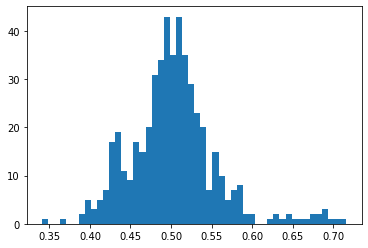

In [8]:
plt.hist(samples.detach().numpy(), bins = 50)
print(theta_0)